In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

from clulib import parse_data

In [43]:
energy = 2000
pidata, _, _ = parse_data('pi0', energy)
gadata, _, _ = parse_data('gamma', energy)
print(pidata.shape, gadata.shape)

(75476, 25, 3) (96471, 25, 3)


In [4]:
from sklearn.model_selection import train_test_split

In [75]:
X = pidata[:, :, 0]
(X / X.sum(axis=1).reshape(-1, 1)).sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [97]:
def preprocess_data(data):
    X = data[:, :, 0]
    sums = X.sum(axis=1)
    return X / sums.reshape(-1, 1), sums
#     return X, sums

In [98]:
def make_data(pidata, gadata):
    pidata0, epi = preprocess_data(pidata)
    gadata0, ega = preprocess_data(gadata)
    print(pidata0.shape)
    print(gadata0.shape)
    X = np.vstack((pidata0, gadata0))
    y = np.concatenate((
        np.zeros(pidata0.shape[0], dtype=int),
        np.ones(gadata0.shape[0], dtype=int)
    ))
    return train_test_split(X, y, test_size=0.2, random_state=47)

In [99]:
X_train, X_test, y_train, y_test = make_data(pidata, gadata)
X_train.shape

(75476, 25)
(96471, 25)


(137557, 25)

In [114]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

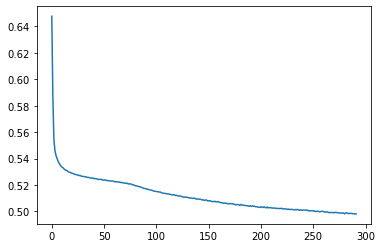

In [115]:
plt.plot(clf.loss_curve_)

In [116]:
clf.score(X_train, y_train)

0.7634362482461816

In [117]:
clf.score(X_test, y_test)

0.7612096539691771

In [118]:
prob = clf.predict_proba(X_test)
prob[0]

array([0.23996774, 0.76003226])

In [123]:
from sklearn.metrics import roc_auc_score

In [125]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.8212689310302317

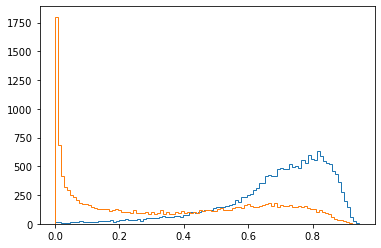

In [134]:
plt.hist(prob[y_test==1][:, 1], bins=100, histtype='step')
plt.hist(prob[y_test==0][:, 1], bins=100, histtype='step');

In [120]:
prob_train = clf.predict_proba(X_train)

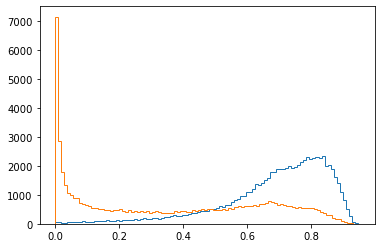

In [133]:
plt.hist(prob_train[y_train==1][:, 1], bins=100, histtype='step')
plt.hist(prob_train[y_train==0][:, 1], bins=100, histtype='step');

In [122]:
clf2 = MLPClassifier(
    random_state=1,
    hidden_layer_sizes=(50, 25),
    max_iter=300).fit(X_train, y_train)

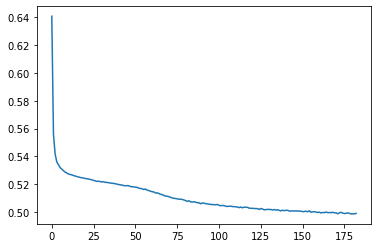

In [139]:
plt.plot(clf2.loss_curve_)

In [128]:
roc_auc_score(y_test, clf2.predict_proba(X_test)[:, 1])

0.8163016334274646

In [130]:
prob2 = clf2.predict_proba(X_test)[:, 1]

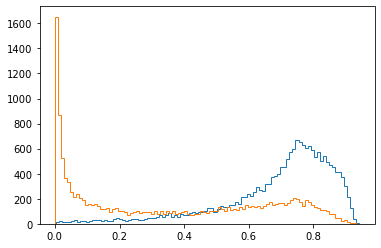

In [132]:
plt.hist(prob2[y_test==1], bins=100, histtype='step')
plt.hist(prob2[y_test==0], bins=100, histtype='step');

In [124]:
from sklearn.ensemble import GradientBoostingClassifier

In [135]:
gbc = GradientBoostingClassifier(random_state=9).fit(X_train, y_train)

In [136]:
roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])

0.8515305039253078

In [137]:
gbc_prob = gbc.predict_proba(X_test)[:, 1]

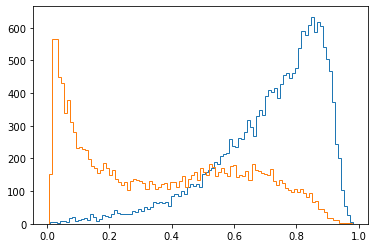

In [138]:
plt.hist(gbc_prob[y_test==1], bins=100, histtype='step')
plt.hist(gbc_prob[y_test==0], bins=100, histtype='step');

In [141]:
from sklearn.model_selection import learning_curve

In [142]:
fitres = learning_curve(GradientBoostingClassifier(random_state=9), X_train, y_train)

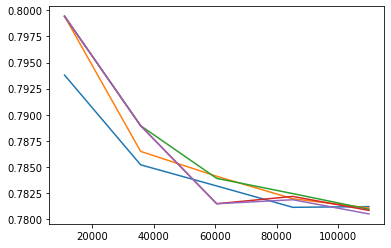

In [150]:
plt.plot(fitres[0], fitres[1])